STAT 453: Intro to Deep Learning and Generative Models (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

In [114]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,pandas,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.31.0

torch     : 2.5.1
pandas    : 2.2.3
matplotlib: 3.10.0



# Linear Regression with Gradient Descent

![](../figures/adaline-concept.png)


Note that linear regression and Adaline are very similar. The only difference is that we apply a threshold function for converting the outputs from continuous targets for predictions. The derivative and training procedure are identical to Adaline though. You can compare the two notebooks (this one and `adaline-sgd.ipynb`) side by side as shown below to see the relationship:

![](../figures/adaline-vs-linreg.png)

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

<br>
<br>

## Load & Prepare a Toy Dataset

In [116]:
df = pd.read_csv('./datasets/linreg-data.csv', index_col=0)
df.tail()

,x1,x2,y
995,-0.942094,-0.835856,-22.324428
996,1.222445,-0.403177,-52.121493
997,-0.112466,-1.688230,-57.043196
998,-0.403459,-0.412272,-27.701833
999,0.021351,-0.499017,-9.804714


In [117]:
# Assign features and target

X = torch.tensor(df[['x1', 'x2']].values, dtype=torch.float)
y = torch.tensor(df['y'].values, dtype=torch.float)

# Shuffling & train/test split

torch.manual_seed(123)
# shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
#
# X, y = X[shuffle_idx], y[shuffle_idx]

# percent70 = int(shuffle_idx.size(0)*0.7)
percent70 = int(y.size(0) *0.7)

# X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
# y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

X_train, X_test = X[:percent70], X[percent70:]
y_train, y_test = y[:percent70], y[percent70:]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

<br>
<br>

## Implement Linear Regression Model

In [118]:
class LinearRegression1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        net_inputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = net_inputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  

        # (yhat - y)^ 2
		# so derivative -> 2 * (yhat - y)
        grad_loss_yhat = 2*(yhat - y)
        
        grad_yhat_weights = x
        grad_yhat_bias = 1.
        
        # Chain rule: inner times outer
        grad_loss_weights =  torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

<br>
<br>

## Define Training and Evaluation Functions

In [119]:
####################################################
##### Training and evaluation wrappers
###################################################

# mean squared error
def loss(yhat, y):
    return torch.mean((yhat - y)**2)

# batch gradient descent
def train(model, x, y, num_epochs, learning_rate=0.01):
    cost = []
    for e in range(num_epochs):

        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        x, y = x[shuffle_idx], y[shuffle_idx]

        #### Compute outputs ####
        yhat = model.forward(x)

        #### Compute gradients ####
        negative_grad_w, negative_grad_b = model.backward(x, yhat, y)

        #### Update weights ####
        model.weights += learning_rate * negative_grad_w
        model.bias += learning_rate * negative_grad_b

        #### Logging ####
        yhat = model.forward(x) # not that this is a bit wasteful here
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

In [120]:
def train2(model, x, y, num_epochs, learning_rate=0.01):
    cost = []
    for e in range(num_epochs):

        # shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        # x, y = x[shuffle_idx], y[shuffle_idx]

        #### Compute outputs ####
        yhat = model.forward(x)

        #### Compute gradients ####
        negative_grad_w, negative_grad_b = model.backward(x, yhat, y)

        #### Update weights ####
        model.weights += learning_rate * negative_grad_w
        model.bias += learning_rate * negative_grad_b

        #### Logging ####
        yhat = model.forward(x) # not that this is a bit wasteful here
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

## Train Linear Regression Model

In [121]:
model = LinearRegression1(num_features=X_train.size(1))
cost = train(model,
             X_train, y_train,
             num_epochs=20,
             learning_rate=0.05)

model2 = LinearRegression1(num_features=X_train.size(1))
cost2 = train2(model2,
             X_train, y_train, 
             num_epochs=20,
             learning_rate=0.05)


Epoch: 001 | MSE: 1617.02307
Epoch: 002 | MSE: 1382.60925
Epoch: 003 | MSE: 1192.68652
Epoch: 004 | MSE: 1038.80908
Epoch: 005 | MSE: 914.13464
Epoch: 006 | MSE: 813.12012
Epoch: 007 | MSE: 731.27466
Epoch: 008 | MSE: 664.96008
Epoch: 009 | MSE: 611.22864
Epoch: 010 | MSE: 567.69238
Epoch: 011 | MSE: 532.41638
Epoch: 012 | MSE: 503.83322
Epoch: 013 | MSE: 480.67276
Epoch: 014 | MSE: 461.90616
Epoch: 015 | MSE: 446.69955
Epoch: 016 | MSE: 434.37769
Epoch: 017 | MSE: 424.39304
Epoch: 018 | MSE: 416.30228
Epoch: 019 | MSE: 409.74612
Epoch: 020 | MSE: 404.43344
Epoch: 001 | MSE: 1617.02307
Epoch: 002 | MSE: 1382.60938
Epoch: 003 | MSE: 1192.68665
Epoch: 004 | MSE: 1038.80908
Epoch: 005 | MSE: 914.13464
Epoch: 006 | MSE: 813.12018
Epoch: 007 | MSE: 731.27472
Epoch: 008 | MSE: 664.96002
Epoch: 009 | MSE: 611.22864
Epoch: 010 | MSE: 567.69226
Epoch: 011 | MSE: 532.41638
Epoch: 012 | MSE: 503.83313
Epoch: 013 | MSE: 480.67273
Epoch: 014 | MSE: 461.90616
Epoch: 015 | MSE: 446.69958
Epoch: 016 |

<br>
<br>

## Evaluate Linear Regression Model

### Plot MSE

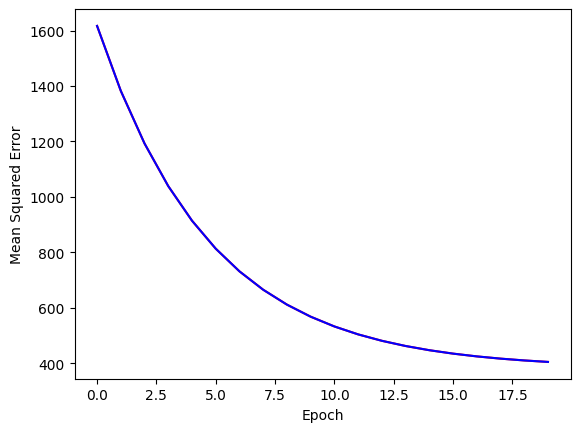

In [122]:
plt.plot(range(len(cost)), cost, color='red')
plt.plot(range(len(cost2)), cost2, color='blue')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [123]:
train_pred = model.forward(X_train)
test_pred = model.forward(X_test)

print('Train MSE: %.5f' % loss(train_pred, y_train))
print('Test MSE: %.5f' % loss(test_pred, y_test))

Train MSE: 404.43344
Test MSE: 410.58975


<br>
<br>

### Compare with analytical solution

In [124]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[-0.1141],
        [34.2945]])
Bias tensor([-0.9195])


In [125]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train)
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[3.8628e-02],
        [3.9061e+01]])
Analytical bias tensor([-1.0468])


<br>
<br>

## (Ungraded) HW Exercises

Modify the `train()` function such that the dataset is shuffled prior to each epoch. Do you see a difference -- Yes/No? Try to come up with an explanation for your observation.

